In [12]:
# Import des librairies
# Base
%matplotlib inline
import numpy as np # type: ignore
import pandas as pd # type: ignore
import time,os
import cv2# type: ignore

# Data Viz
import matplotlib.pyplot as plt# type: ignore
import seaborn as sns# type: ignore

# Modèle
import tensorflow as tf# type: ignore
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,MaxPool2D# type: ignore
from keras import layers, models, optimizers, losses, metrics,callbacks,utils,Model,Sequential,Input# type: ignore

# Rééchantillonnage 
from sklearn.model_selection import train_test_split# type: ignore

# Evaluation et métriques
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay# type: ignore

# Transformation
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
print("tensorflow version",tf.__version__)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#Sauvegarde variables
import pickle

tensorflow version 2.16.1
Num GPUs Available:  0


Fonctions

In [5]:
def my_preprocessing_func(img):
    image = np.array(img)
    return image / 255

Selection des données

In [6]:
print('getcwd:      ', os.getcwd())
#selection only_healthy
if 1==1:
    directory1=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\New_Plant_Diseases_Dataset_only_healthy\train")
    directory2=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\New_Plant_Diseases_Dataset_only_healthy\valid")
    directory3=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\New_Plant_Diseases_Dataset_only_healthy\test")
#selection all
if 0==1:
    directory1=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\01_New_Plant_Diseases_Dataset\train")
    directory2=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\01_New_Plant_Diseases_Dataset\valid")
    directory3=(r"D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\01_New_Plant_Diseases_Dataset\test")   
print('le filename de img_color est :', directory1)

getcwd:       d:\Adrien et Sarah\Documents\GitHub\JAN24_PLANT_RECOGNITION\notebooks
le filename de img_color est : D:\Adrien et Sarah\Téléchargements\DATASETS\Maladie_sur_les_plantes\New_Plant_Diseases_Dataset_only_healthy\train


Téléchargez le jeu de données

In [7]:
#augmentation de donnée : rotation_range=10, width_shift_range=0.1,  height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True,
train_gen = ImageDataGenerator(preprocessing_function=my_preprocessing_func)
val_gen = ImageDataGenerator(preprocessing_function=my_preprocessing_func)   
test_datagen = ImageDataGenerator(preprocessing_function=my_preprocessing_func)

train_generator=train_gen.flow_from_directory(
    directory=directory1,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode="categorical"
)

valid_generator = val_gen.flow_from_directory(
    directory=directory2,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=directory3,
    target_size=(256, 256),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 22294 images belonging to 12 classes.
Found 5371 images belonging to 12 classes.
Found 207 images belonging to 12 classes.


Creer un model CNN

In [8]:
cnn = Sequential()
#cnn.add(Input(shape=(256,256,3),dtype=tf.float32))
cnn.add(layers.Conv2D(32,(3, 3),padding='same',activation='relu',input_shape=(256,256,3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(256, (3, 3), activation='relu'))
cnn.add(layers.Dropout(0.25))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(units=512,activation='relu'))#1500
cnn.add(layers.Dropout(0.4)) #To avoid overfitting
#Output Layer
cnn.add(layers.Dense(units=len(train_generator.class_indices),activation='softmax'))
cnn.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
cnn.summary()

d:\Adrien et Sarah\Documents\GitHub\JAN24_PLANT_RECOGNITION\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,155,532 (393.51 MB)

 Trainable params: 103,155,532 (393.51 MB)

 Non-trainable params: 0 (0.00 B)

Ajustement/Entraînement du modèle

In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                        patience = 5,
                                        mode = 'min',
                                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                        patience=5,
                                        factor=0.5,
                                        verbose=2,
                                        mode='min',
                                        min_lr = 1e-10) # type: ignore

In [11]:

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
#Model.fit_generator est obsolète depuis TensorFlow 2.1.0
#vous pouvez le corriger en utilisant Model.fit pour utiliser ImageDataGenerator comme entrée

# entrainement avec la méthode .fit()
history = cnn.fit(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=15,#9
                    callbacks=[early_stopping,lr_plateau]
)
#cnn.save(r"..\..\models\cnn1.keras")
# Saving the objects:
with open('objs.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([history], f)

Epoch 1/15
  6/696 ━━━━━━━━━━━━━━━━━━━━ 15:43 1s/step - accuracy: 0.0611 - loss: 17.1296   

KeyboardInterrupt: 

Évaluer le modèle

In [14]:
#restoration model
#print('getcwd:      ', os.getcwd())
cnn=models.load_model(r"..\..\models\cnn1.keras")
# Getting back the objects:
with open(r'..\models\objs.pkl') as f:  # Python 3: open(..., 'rb')
    history = pickle.load(f)

getcwd:       d:\Adrien et Sarah\Documents\GitHub\JAN24_PLANT_RECOGNITION\notebooks


FileNotFoundError: [Errno 2] No such file or directory: 'objs.pkl'

NameError: name 'history' is not defined

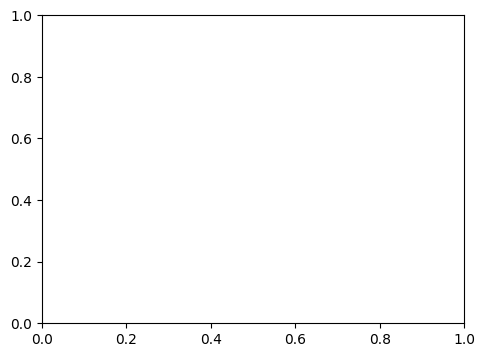

In [31]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model_loss_by_epoch")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

Prédire la sortie

In [57]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=cnn.predict(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step


In [58]:
valid_generator.reset()
true_classes = valid_generator.classes
pred=cnn.predict(valid_generator)

predicted_class_indices_v=np.argmax(pred,axis=1)

labels_v = (train_generator.class_indices)
labels_v = dict((v,k) for k,v in labels_v.items())
predictions_v = [labels[k] for k in predicted_class_indices_v]

168/168 ━━━━━━━━━━━━━━━━━━━━ 32s 189ms/step


enregistrez les résultats dans un fichier CSV.En option

In [59]:
labels.items()

dict_items([(0, 'Apple___healthy'), (1, 'Blueberry___healthy'), (2, 'Cherry_(including_sour)___healthy'), (3, 'Corn_(maize)___healthy'), (4, 'Grape___healthy'), (5, 'Peach___healthy'), (6, 'Pepper,_bell___healthy'), (7, 'Potato___healthy'), (8, 'Raspberry___healthy'), (9, 'Soybean___healthy'), (10, 'Strawberry___healthy'), (11, 'Tomato___healthy')])

In [60]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames})
results["Predictions"]=predictions
#results.to_csv("results.csv",index=False)

                                   precision    recall  f1-score   support

                  Apple___healthy       0.81      1.00      0.90        13
              Blueberry___healthy       0.74      0.94      0.83        18
Cherry_(including_sour)___healthy       1.00      1.00      1.00        20
           Corn_(maize)___healthy       1.00      1.00      1.00        15
                  Grape___healthy       0.80      1.00      0.89        12
                  Peach___healthy       1.00      1.00      1.00        15
           Pepper,_bell___healthy       1.00      0.89      0.94        18
                 Potato___healthy       0.89      0.73      0.80        22
              Raspberry___healthy       0.93      1.00      0.97        14
                Soybean___healthy       1.00      0.91      0.95        23
             Strawberry___healthy       1.00      0.69      0.82        13
                 Tomato___healthy       1.00      1.00      1.00        24

                       

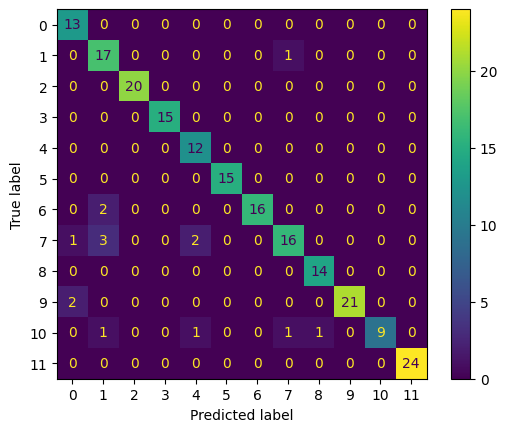

In [61]:
#results.to_csv("results.csv",index=False)
#Get True Values of classes,label
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
#Get matrix
report = classification_report(true_classes, predicted_class_indices, target_names=class_labels)
print(report)    
ConfusionMatrixDisplay.from_predictions(true_classes, predicted_class_indices);
print("On constate avec la matrice de confusion que le modèle retenu parvient à prédire environ ")

                                   precision    recall  f1-score   support

                  Apple___healthy       0.91      0.90      0.90       489
              Blueberry___healthy       0.83      0.98      0.90       436
Cherry_(including_sour)___healthy       0.93      0.94      0.93       436
           Corn_(maize)___healthy       0.97      0.98      0.98       450
                  Grape___healthy       0.93      0.96      0.94       411
                  Peach___healthy       0.97      0.95      0.96       417
           Pepper,_bell___healthy       0.93      0.84      0.88       479
                 Potato___healthy       0.92      0.81      0.87       436
              Raspberry___healthy       0.96      0.88      0.92       431
                Soybean___healthy       0.92      0.93      0.92       482
             Strawberry___healthy       0.89      0.95      0.92       443
                 Tomato___healthy       0.98      0.97      0.98       461

                       

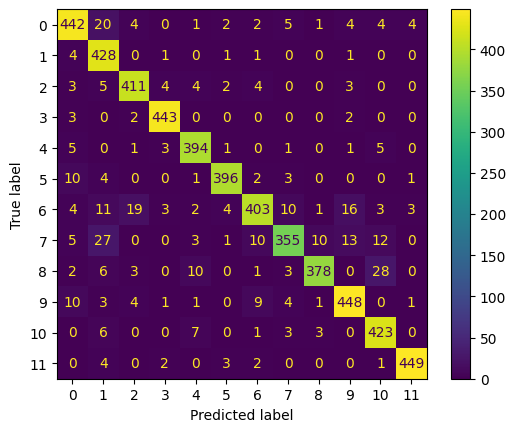

In [62]:
#Get True Values of classes,label
true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())
#Get matrix
report = classification_report(true_classes, predicted_class_indices_v, target_names=class_labels)
print(report)    

ConfusionMatrixDisplay.from_predictions(true_classes, predicted_class_indices_v);

Visualisation de chaque canal dans chaque activation intermédiaire

In [13]:
#Recuperation une image de train
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
x_train, y_train = next(train_generator)
y_train = [labels[k] for k in y_train.argmax(axis=1)]

shape (256, 256, 3)
reshape (1, 256, 256, 3)


Text(0.5, 1.0, 'Data input')

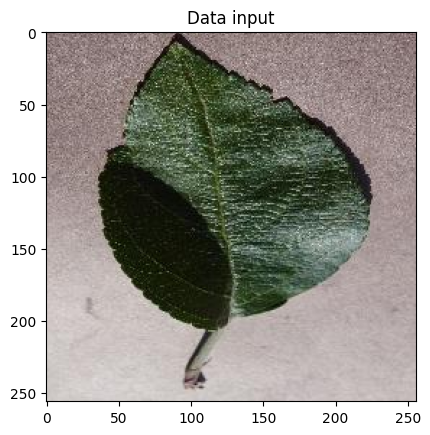

In [14]:
from turtle import title


print("shape",x_train[0].shape)
d=x_train[0].reshape(1,256,256,3)
print("reshape",d.shape)
plt.imshow(d[0]);
plt.title("Data input")

In [15]:
# Extrait les sorties (outputs) des 12 couches supérieures
layer_outputs = [layer.output for layer in cnn.layers[:15]] 

# Crée un modèle qui retournera ces sorties (outputs), étant donné l'entrée (input) du modèle.
activation_model = models.Model(inputs=cnn.layers[0].input, outputs=layer_outputs) 

In [16]:
# Retourne une liste de cinq tableaux NumPy : un tableau par activation de couche
activations = activation_model.predict(d) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


(1, 256, 256, 32)


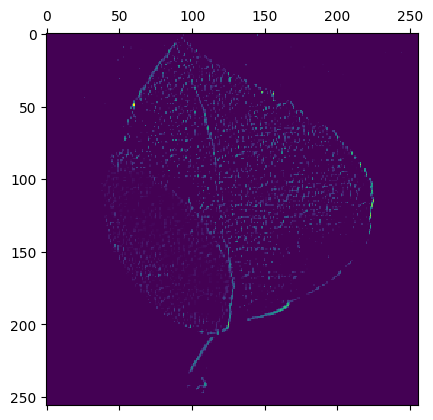

In [17]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis');

C:\Users\artho\AppData\Local\Temp\ipykernel_1848\2733394032.py:21: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


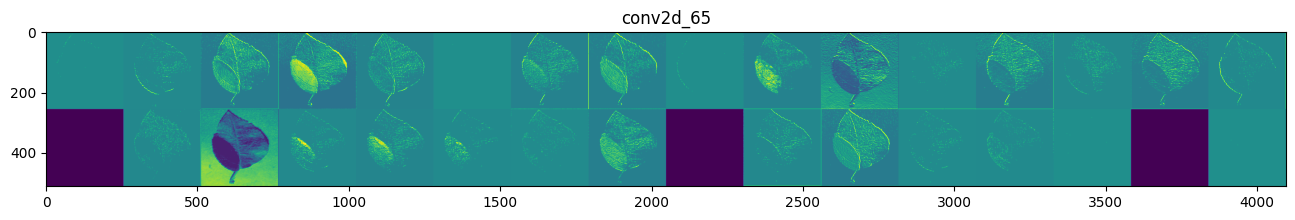

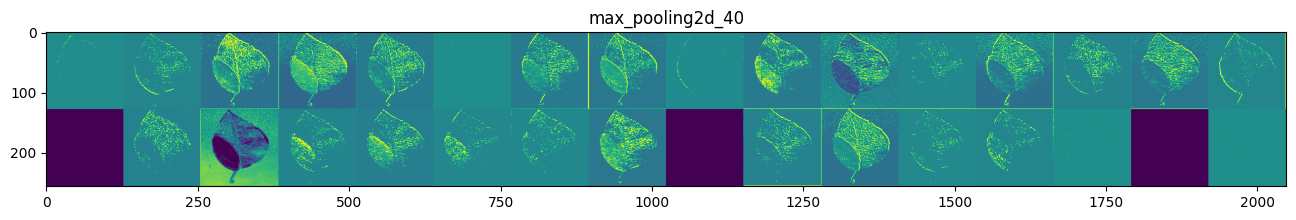

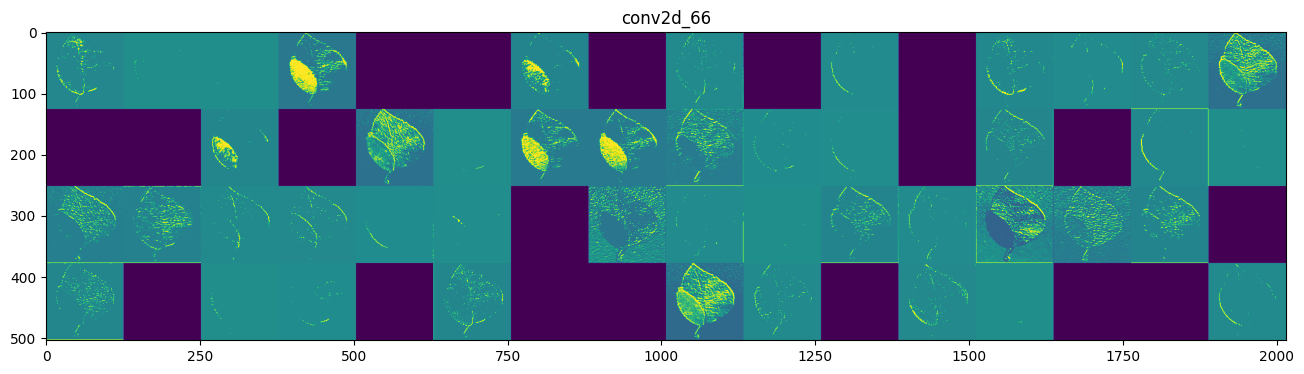

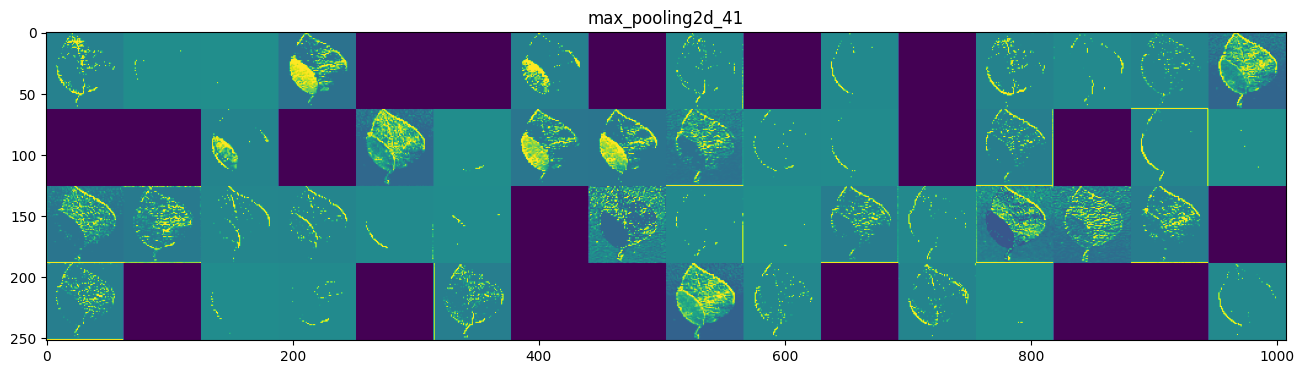

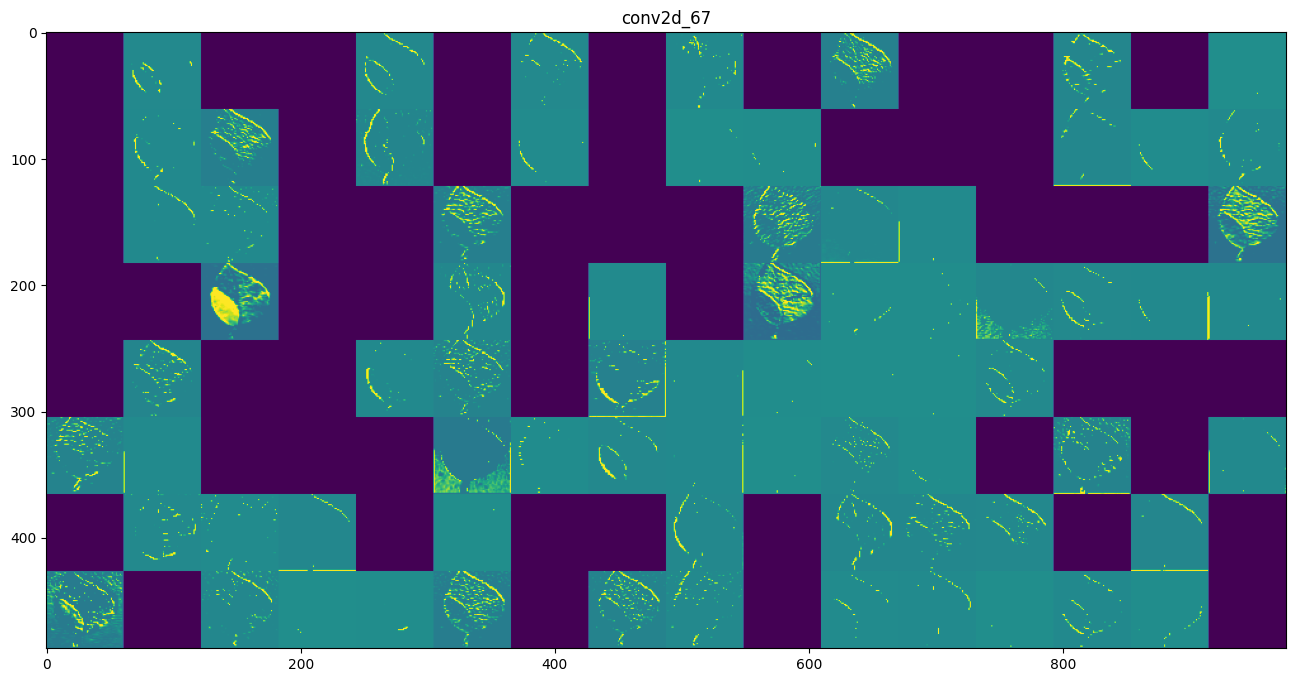

In [19]:
layer_names = []
for layer in cnn.layers[:5]:
    layer_names.append(layer.name) # Noms des couches, afin que vous puissiez les intégrer à votre graphique

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Affiche les cartes des features
    n_features = layer_activation.shape[-1] # Nombre de features dans la carte des features
    size = layer_activation.shape[1] # La carte des features a la forme/dimension suivante : (1, size, size, n_features).
    n_cols = n_features // images_per_row # Classer les canaux d'activation dans cette matrice
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Classer chaque filtre dans une grande grille horizontale
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-traitement de la feature pour la rendre visuellement acceptable.
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Affiche la grille
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')